# Hackathon 1, statistics.

This project illustrates the statistics part of the course LEPL1109. In the first part of the project, you will study the China water pollution by analyzing a dataset providing the water pollution levels collected from various monitoring stations across 10 major provinces in China throughout the year 2023. In the second part of the project, you will analyze a dataset containing high-frequency time-series  data collected from an industrial boiler operating in a chemical plant.

## Report content

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

•	Do not comment your results directly into cells of code. Use instead a Markdown cell. 

•	"Dry" code or results not followed by a minimum of analysis / comments will be penalized.


## Report submission

•	Deadline, see moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “APP” on Moodle and the subsection “Soumission du rapport”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.


## Names and Noma of participants:

Part. 1: Lepoutre Florian - 45122300

Part. 2: Peffer Jean-Louis - 72232300

Part. 3: Schlicker Ulrick - 41982300

Part. 4: Jamblin Otto - 36402301

Part. 5: Thiry John - 45942300

Part. 6: Gangolf Pierre - 40492300

# China Water Pollution 

This dataset provides  water pollution levels collected from various monitoring stations across 10 major provinces in China throughout the year 2023. The data  includes  parameters such as pH, turbidity, chemical and biological oxygen demand, nutrient levels, and heavy metal concentrations. These indicators are widely used by environmental monitoring agencies to assess water quality for ecological, human, and industrial impacts.

We will focus on the Water Quality Index. 

#### Import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sc
import statsmodels.api as sm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern
import matplotlib.pyplot as plt

## 1. Basic statistics

1.a) Load the dataset 'china_water_pollution_data_hack.csv'. Convert Province, City  to categorical variables. (**0.5 pt**) 

In [7]:
# CSV reading
data = pd.read_csv('./China_water_pollution/china_water_pollution_data_hack.csv')

# Convert to categorical variables
data['Province'] = data['Province'].astype('category')
data['City'] = data['City'].astype('category')


1.b) Calculate the mean, variance, median, 25% and 75% quantiles of the water quality index (which ranges from 0 to 100) for all cities in the dataset. Comment your results! (**1.5 pts**)

In [ ]:
# Variable extraction
desc = data.groupby("City")["Water_Quality_Index"].describe()
desc["variance"] = data.groupby("City")["Water_Quality_Index"].var()
desc["median"] = data.groupby("City")["Water_Quality_Index"].median()
print(desc[["mean","variance","median","25%","75%"]])
print("")

                mean   variance     median        25%        75%
City                                                            
Beijing    58.882070  24.447735  58.333333  56.070042  61.736875
Chengdu    54.405592  24.594466  54.795208  51.389167  57.267733
Dali       54.181129  31.266031  53.974083  50.662117  58.027806
Guangzhou  58.360981  34.337685  58.319458  54.687812  63.104396
Hangzhou   58.939443  30.310407  58.333333  55.000000  61.715646
Jinan      58.732275  24.629255  58.333333  55.000000  61.819708
Kunming    58.748408  24.475260  59.056500  55.251000  61.666667
Luoyang    53.289280  29.065348  53.238983  49.636475  56.347404
Mianyang   58.752162  29.738358  58.333333  55.000000  63.333333
Nanjing    54.166608  28.179058  53.842825  50.631592  57.835500
Ningbo     58.666299  27.020291  58.263958  55.000000  61.666667
Qingdao    58.393345  24.494630  58.333333  54.840438  61.757271
Shanghai   59.444212  22.332776  59.708625  56.409979  63.175021
Shenzhen   58.984718  27.

C:\Users\Florian\AppData\Local\Temp\ipykernel_26416\536806158.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = data.groupby("City")["Water_Quality_Index"].describe()
C:\Users\Florian\AppData\Local\Temp\ipykernel_26416\536806158.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc["variance"] = data.groupby("City")["Water_Quality_Index"].var()
C:\Users\Florian\AppData\Local\Temp\ipykernel_26416\536806158.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adop

Comment here: The mean values are more or less the same, between 53 and 60. The standard deviations are low compred to the mean values. It means that the values are regrouped around the mean. We can also see that the median is close to the mean for all cities.

## 2. Hypothesis tests 

2.a) Check with a Student's T test that the average water quality index is the same in Shenzhen and Dali: $$H_0: \mu_{Shenzhen} = \mu_{Dali},\\
H_1: \mu_{Shenzhen} \neq \mu_{Dali}.$$ Calculate all statistics and p-value without recourse to other functions than statistical distributions (use course's formula). Use a confidence level of 5%. Take care to comment your conclusions. Are all assumptions required to perform this test sastisfied? Which additional test do you have to do to validate your result? (**2.5 pts**)

In [ ]:
#reading of the data
Shenzhen_data = data[data["City"] == "Shenzhen"]["Water_Quality_Index"]
Dali_data = data[data["City"] == "Dali"]["Water_Quality_Index"]

# number of data for the city of Shenzhen
n1 = len(Shenzhen_data)
# print("n1 "+str(n1))

# number of data for the city of Dali
n2 = len(Dali_data)
# print("n2 "+str(n2))

# degree de liberty
df=n1+n2-2
# print("df "+str(df))

# average data for the city of Shenzhen
X1bar=np.mean(Shenzhen_data)
# print("X1bar "+str(X1bar))

# average data for the city of Dali
X2bar=np.mean(Dali_data)
# print("X2bar "+str(X2bar))

# calulation of  empirical variances
sum=0
for x1 in Shenzhen_data:
    sum=sum+(x1-X1bar)**2
S1=np.sqrt((1/(n1-1))*sum)
# print("S1^2 " + str(S1**2))

sum=0
for x2 in Dali_data:
    sum=sum+(x2-X2bar)**2
S2=np.sqrt((1/(n2-1))*sum)
# print("S2^2 "+str(S2**2))

Spool = np.sqrt(((n1-1)*(S1**2)+(n2-1)*(S2**2))/(df))

T=((X1bar-X2bar)/(Spool*np.sqrt((1/n1)+(1/n2))))
# print("T " + str(T))
# calculation of the p-value
pvalue= 2*(1-sc.t.cdf(abs(T),df,loc=0,scale=1))
print("pvalue :", pvalue)

# Are all assumptions verified ?
print("Is sigma1 = sigma2 ?")
print("H0 : sigma1 == sigma2")
print("H1 : sigma1 < sigma2")

F=(S1**2)/(S2**2)
# print(F)

pvaluesigma= (sc.f.cdf(abs(F),dfn=n1-1,dfd=n2-1))
print("pvalue sigma :" +str(pvaluesigma))
print("We do not reject H0 because p-value > alpha = 0.05")

# We can also verify that our datas follows a Normal Distribution
print("Shenzhen_data normal ? normal if pvalue >0.05 " +str(sc.shapiro(Shenzhen_data)))
print("Dali_data are normal ? normal if pvalue >0.05 " + str(sc.shapiro(Dali_data)))


pvalue : 2.475797344914099e-13
Is sigma1 = sigma2 ?
H0 : sigma1 == sigma2
H1 : sigma1 < sigma2
pvalue sigma :0.21260326924229164
On ne peut pas rejeter H0 car p-value > alpha = 0.05
Shenzhen_data normal ? normal if pvalue >0.05 ShapiroResult(statistic=0.988514414770562, pvalue=0.23501834293248447)
Dali_data are normal ? normal if pvalue >0.05 ShapiroResult(statistic=0.9915554084847528, pvalue=0.5472895706417602)


Comment here: Our p-value is 2.475797344914099e-13. It means that we can reject $H_0$, and that the average quality water index is probably not equal in Shenzhen and in Dali.

Comment here:
The assumptions to perform this test are multiple : the populations are independent, the data follow a normal distribution and the variance of the two variables are equal.

First of all, we can assume that it is independent because the distance between Shenzhen and Dali is 1800 km.

Then we can check if the two sets of datas follow a normal distribution with a scipy.stats method : sc.shapiro(). It gives us a p-value of 0.235 and 0.547, which means that we do not the null hypothesis ($H_0$ : the data was drawn from a normal distribution).

Finally, we can check if the variances are equal with : $$H_0 : \sigma_1 = \sigma_2 $$ $$H_1 : \sigma_1 < \sigma_2$$ Using a Fisher distribution, we get a p-value of 0.21, which means that we can not reject $H_0$.

2.b) 'Wuhan', 'Luoyang', 'Chengdu', 'Nanjing', 'Dali' seems to have similar (and low) water quality index. Test the assumption: $$H_0:  \mu_{Wuhan} = \mu_{Luoyang}= \mu_{Chengdu} = \mu_{Nanjing} =\mu_{Dali}.$$
**Hint**: reformulate the problem as a linear regression.

(**2 pts**)

In [ ]:
data = pd.read_csv('./China_water_pollution/china_water_pollution_data_hack.csv')
Wuhan_data = data[data["City"] == "Wuhan"]["Water_Quality_Index"] # X1 = 1 if the value comes from Wuhan and 0 otherwise
Luoyang_data = data[data["City"] == "Luoyang"]["Water_Quality_Index"] # X2=1 if the value comes from Luoyang and 0 otherwise
Chengdu_data = data[data["City"] == "Chengdu"]["Water_Quality_Index"] # X3 = 1 if the value comes from Chengdu and 0 otherwise
Nanjing_data = data[data["City"] == "Nanjing"]["Water_Quality_Index"] # X4 = 1 if the value comes from Nanjing and 0 otherwise
Dali_data = data[data["City"] == "Dali"]["Water_Quality_Index"]

size1=len(Wuhan_data)
size2=len(Luoyang_data)
size3=len(Chengdu_data)
size4=len(Nanjing_data)
size5=len(Dali_data)

n=size1+size2+size3+size4+size5


X=np.zeros((n,4))
for i in range(size1): # here we create a matrix , it column are the variables X1,X2 ...  define before, and it row are filled with 1 or 0 with the definitions
# of the variables
    X[i,0]=1
for i in range(size2):
    X[i+size1,1]=1
for i in range(size3):
    X[i+size1+size2,2]=1
for i in range(size4):
    X[i+size1+size2+size3,3]=1

Y=np.concatenate((Wuhan_data,Luoyang_data,Chengdu_data,Nanjing_data,Dali_data)) # we  concatenate all the results in one vector

Xm = sm.add_constant(X) # we add a constante at our regression
d=4
# print(len(Xm),len(Xm[0]))
# print(len(Y))
model = sm.OLS(Y,Xm) 

results=model.fit()# method which fit a linear regression at our values

#print(results.summary())

#caculation of SST
ybar=np.mean(Y)        
sst=np.sum((Y-ybar)**2)

#calculation of SSE
Ypredict=results.predict(Xm)
sse= np.sum((Y-Ypredict)**2)

#calculation of SSR
ssr=np.sum((Ypredict-ybar)**2)



F=(ssr/d)/(sse/(n-d-1))
print("F (with method) "+str(results.fvalue))
print("F is " + str(F))

print("ddl numerator "+str(d))
print("ddl denominator "+str(n-d-1))
print("SSR "+str(ssr))
print("SSE "+str(sse))
print("SST "+str(sst))

pvalue = (1-sc.f.cdf(F,dfn=d,dfd=n-d-1)) # calculation of the pvalue 

if pvalue>0.05 and results.f_pvalue>0.05:
    print("We don't reject H_0 :")
    print("the p-value of the test if the different expectations are equals is "+ str(pvalue))
    print("the p-value of the test if the different expectations are equals is (with method) " +str(results.f_pvalue))
else:
    print("We reject H_0 :")
    print("the p-value of the test if the different expectations are equals is "+ str(pvalue))
    print("the p-value of the test if the different expectations are equals is (with method) " +str(results.f_pvalue))
print("R^2 is " + str( 1- (sse/sst)))




F (with method) 0.9645238509218522
F is 0.9645238509222983
ddl numerator 4
ddl denominator 749
SSR 113.78628445622768
SSE 22090.15541093662
SST 22203.941695392794
We don't reject H_0 :
the p-value of the test if the different expectations are equals is 0.4262199233199301
the p-value of the test if the different expectations are equals is (with method) 0.4262199233201662
R^2 is 0.005124598416675896


Comment here: Using a linear regression, we get a p-value of 0.426, which is greater than alpha = 0.05. It means that we do not reject $H_0$.

## 3. Regressions

3.a) Propose a regression model which explains the Water_Quality_Index as a function of other explanatory variables, **for the city of Shanghai**. Split your data set into a training set (80% of the data) that you use for fitting the model and a test set (20% of the data) on which you test the accuracy of the model. 

* Use the OLS() function of the package statsmodels.api to perform the linear regression. 
* Comment your results (goodness of fit, R2, F-stat and T-stats of coefficients)
* Identify potential non-relevant covariates
* Calculate the MAE on the test and training sets. 

(**3 pts**)

In [ ]:
#code here 
from sklearn.model_selection import train_test_split


df = pd.read_csv('./China_water_pollution/china_water_pollution_data_hack.csv')
shanghai = df[df['City'] == 'Shanghai'].copy() # Keep only rows where the 'City' column equals 'Shanghai'.

# X contains all explanatory variables that may influence water quality.
X = shanghai[['Water_Temperature_C','pH','Dissolved_Oxygen_mg_L','Conductivity_uS_cm','Turbidity_NTU','Nitrate_mg_L','Nitrite_mg_L','Ammonia_N_mg_L','Total_Phosphorus_mg_L','Total_Nitrogen_mg_L','COD_mg_L','BOD_mg_L','Heavy_Metals_Pb_ug_L','Heavy_Metals_Cd_ug_L','Heavy_Metals_Hg_ug_L','Coliform_Count_CFU_100mL']]

# y is the dependent variable we want to predict.
y = shanghai['Water_Quality_Index'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 80% of the data for training, 20% for testing.


X_train_sm = sm.add_constant(X_train)   #Add constant term for OLS regression
X_test_sm = sm.add_constant(X_test)


ols_model = sm.OLS(y_train, X_train_sm).fit()  #Fit the Ordinary Least Squares (OLS) regression model

print(ols_model.summary()) # Display full statistical summary

#Evaluate model performance using Mean Absolute Error (MAE)
mae_train = np.mean(np.abs(y_train - ols_model.predict(X_train_sm)))  
mae_test = np.mean(np.abs(y_test - ols_model.predict(X_test_sm)))

print(f"MAE (train) = {mae_train:.2f}")
print(f"MAE (test) = {mae_test:.2f}")

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.773
Model:                             OLS   Adj. R-squared:                  0.757
Method:                  Least Squares   F-statistic:                     49.32
Date:                 Mon, 27 Oct 2025   Prob (F-statistic):           2.65e-65
Time:                         14:56:01   Log-Likelihood:                -549.08
No. Observations:                  249   AIC:                             1132.
Df Residuals:                      232   BIC:                             1192.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

Comment here: The model shows a good fit (R² = 0.773, Adj. R² = 0.757, both close to 1). The linear regression is globally significant (F = 49.32, 2.65e-65 << 0.05). 

The most important predictors are Dissolved Oxygen (positive effect) and Turbidity, Nitrate, Ammonia, and Total Phosphorus (negative effects). 

Some variables (pH, Water Temperature, Nitrite, Total Nitrogen) are not statistically significant (p > 0.05) and could be removed. 

The model achieves low Mean Absolute Error (MAE_train = 1.75, MAE_test = 1.86), indicating strong predictive performance and little overfitting.

However, the large condition number (5.19×10⁴) suggests strong multicollinearity among predictors, meaning that some explanatory variables are highly correlated.

3.b) Same question as 3.a) but now you use a Gaussian process regression. Use a RBF and Matern kernel and compare MAEs of the 2 models. Which one is the best? (**2 pts**)

In [ ]:
# RBF kernel
kernel_rbf = RBF()  
gpr_rbf = GaussianProcessRegressor(kernel=kernel_rbf, random_state=0)    
gpr_rbf.fit(X_train, y_train)
y_pred_rbf = gpr_rbf.predict(X_test)        # Predict on the test set
mae_rbf = np.mean(np.abs(y_test - y_pred_rbf))  # Compute the Mean Absolute Error (MAE) for RBF predictions

# Matern kernel
kernel_matern = Matern()
gpr_matern = GaussianProcessRegressor(kernel=kernel_matern, random_state=0)
gpr_matern.fit(X_train, y_train)
y_pred_matern = gpr_matern.predict(X_test)      # Predict on the test set
mae_matern = np.mean(np.abs(y_test - y_pred_matern))  # Compute the Mean Absolute Error (MAE) for Matern predictions

print(f"MAE RBF = {mae_rbf:.2f}")
print(f"MAE Matern = {mae_matern:.2f}")


Comment here: The model using the Matern kernel achieved a lower Mean Absolute Error (MAE = 4.83) compared to the RBF kernel (MAE = 8.13). Therefore, the Gaussian Process model with the Matern kernel performs best

# Boiler

![furnace_plotL](boiler/furnace_plotL.PNG)

This dataset contains high-frequency time-series  data collected (every 5 seconds) from an industrial boiler operating in a chemical plant. The boiler is equipped with multiple sensors capturing parameters such as pressure, temperature, flow rate, and oxygen levels. The dataset reflects a real-world industrial scenario. The boiler outlet steam temperature, ranging typically from 530 °C to 545 °C during stable operation, is used as the key indicator of equipment state. Deviations outside this range represent abnormal operating conditions. 

## 4. Poisson Process

4. During stable operations, the outlet steam temperature is in the interval 530 °C to 545 °C. 

a) Load the dataset 'data_boiler.csv', plot the Boiler outlet steam temperature (variable 'TE_8332A.AV_0') and count the number of times this temperature is outside this normal range. What do you observe? (**1 pt**)

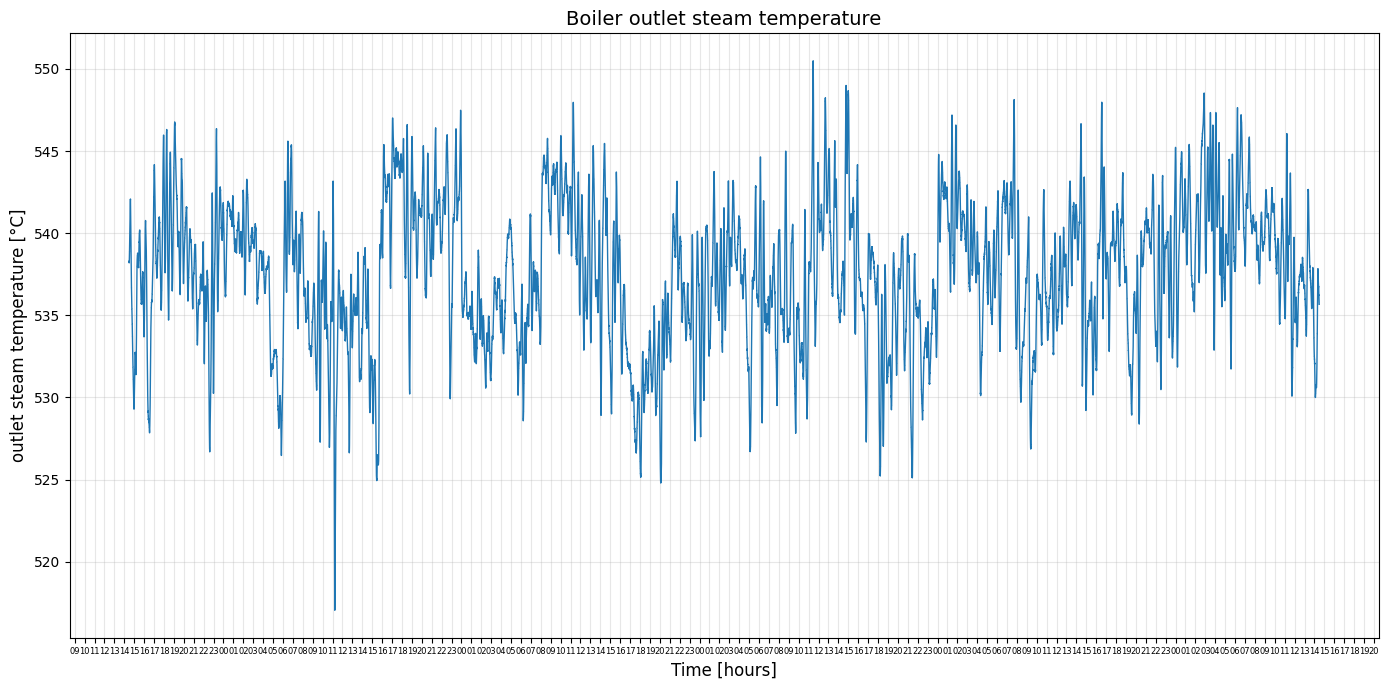

the number of times the boiler is outside its normal temperature range is: 7037
the probability of the boiler to be outside its normal tempurature range is: 0.08144675925925926
the number of times the boiler is inside its normal temperature range is: 79327
the probability of the boiler to be inside its normal tempurature range is: 0.9181365740740741


In [16]:

import matplotlib.dates as mdates 

df = pd.read_csv('Boiler\data_boiler.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

#plot
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(df.index,df['TE_8332A.AV_0#'],linewidth=1)

# Format x-axis
ax.set_title('Boiler outlet steam temperature', fontsize=14)
ax.set_xlabel('Time [hours]', fontsize=12)
ax.set_ylabel('outlet steam temperature [°C]', fontsize=12)
ax.grid(True, alpha=0.3)

# Set date format and intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # toute les 1H
plt.xticks( fontsize=6)
plt.tight_layout()

plt.show()

#counting number of times outside normale range 
tf = pd.read_csv('Boiler\data_boiler.csv')
temp_val = tf['TE_8332A.AV_0#'].tolist()

ntimes_out = 0
for i in range(0,len(temp_val)):
    if ((temp_val[i] > 545) or (temp_val[i] < 530)):
        ntimes_out += 1

print(f"the number of times the boiler is outside its normal temperature range is: {ntimes_out}")

prob_out = ntimes_out/len(temp_val)

print(f"the probability of the boiler to be outside its normal tempurature range is: {prob_out}")

#esperance of finding outside its normal temp range (avec x_i -> la temperature recolter du boiler) (V.A = {1 si 530 [°C] < x_i < 545 [°C]
#                                                                                                       {0 sinon 


#esperance of finding inside its normal temp
ntimes_in = 0
for i in range(0,len(temp_val)):
    if ((temp_val[i] < 545) and (temp_val[i] > 530)):
        ntimes_in += 1

print(f"the number of times the boiler is inside its normal temperature range is: {ntimes_in}")

prob_in = ntimes_in/len(temp_val)

print(f"the probability of the boiler to be inside its normal tempurature range is: {prob_in}")


Comment here: We can observe that the number of times the boiler is outside its normal temperature range is 7037, this is low compared to the number of times it is inside its normal tempurature range, the probabilities of finding a temperature outside its normal range on the whole period of time is 0.082 and finding it inside its normal range is 0.918.

b) A Poisson process, denoted by $N_t$ is a counting process. The number of events observed during an interval [0,t] is distributed according to a Poisson law with a parameter $\lambda \times t$. Using the method of moment, estimate $\lambda \times t$, the frequency of overheating **or** underheating (i.e. when we are outside the interval) per hour.

Remark: do not forget that time-series data are collected every 5 seconds.

(**1.5 pt**)

In [23]:
import scipy.stats as sci
time_T = (len(temp_val)*5)/3600
lamba = ntimes_out /time_T 
print(f"parametre lambda_1 is: {lamba}")
lamba2 = ntimes_in/time_T
print(f"parametre lambda_2 is: {lamba2}")


parametre lambda is: 58.641666666666666
parametre lambda2 is: 661.0583333333333


c) Calculate the probability of observing more ( >= ) than 50 abnormal temperatures on 1h. (**1 pt**)

In [ ]:
#P(X >= 50) = (1 - P(X <= 49))
# 
# P(X <= 49):
pless49 = sci.poisson.cdf(49,lamba)
pmore50 = 1 - pless49 

notpmore49 = 1 - sci.poisson.cdf(49,lamba2)

print(f"probability of observing more ( >= ) than 50 abnormal temperatures on 1h: {pmore50}")
print(f"probability of observing more ( >= ) than 50 normal temperatures on 1h: {notpmore49}")

probability of observing more ( >= ) than 50 abnormal temperatures on 1h: 0.8858156859855504
probability of observing more ( >= ) than 50 normal temperatures on 1h: 1.0


Comment here: At first we can think that the probability of observing more than 50 abnormal temperature in 1h (0.88) is very high and that it would suggest that the boiler is not stable in the short term. But comparing it to the probability of observing more than 50 normal temperatures in 1h (probability of 1) suggest otherwise that the boiler is stable in the short term, we conclude this because the boiler will not be staying a long time in a abnormal temperature range, it will quickly come back to a normal temperature range. Furthermore by compraing the paramatres $\lambda_{1} = 58.64$ (the frequency of overheating **or** underheating per hour) and $\lambda_2 = 661$ (the frequency of no overheating **and** underheating (i.e. when we are inside the interval) per hour) we can see that most of the time the boiler is inside it's normal temperature range. 

## 5. Fit of distributions and forecasting 

5. The induced draft fan motor current must in normal condition stay below 30 Amp. A current above 30 Amp may cause damage to the installation. 

a) Fit a Gamma and an exponentiated Weibull distributions to the variable YFJ3_AI.AV_0. Compare histograms and  densities, and choose the most appropriate distribution. Using the most appropriate distribution, determine the probability that over a similar period of time, we observe a peak of induced draft fan motor current above 30 Amp. 
(**3 pts**)

alpha =52.624051775157966
loc =15.629113736275116
beta =0.1349122251329703
exp =18.01768005409685
k =3.187632729221556
loc =15.629113736275116
lam =6.262483575734004


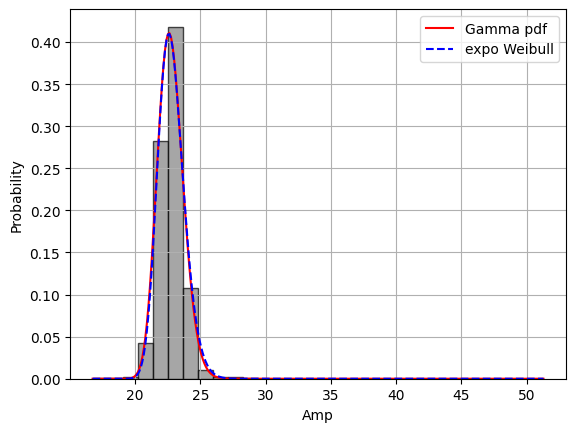

loi de vraisemblance gamma-119739.70951714725
loi de vraisemblance expo Weibull-119762.99944072591
On choisit la distribution Gamma
La probabilité d'avoir un pic au dessus de 30Amp est de 2.651745711901299e-09


In [ ]:
variable = df['YFJ3_AI.AV_0#'] 

n, bins, patches = plt.hist(variable, bins=30, density=True, color='grey', edgecolor='black', alpha=0.7)
plt.xlabel('Amp')
plt.ylabel('Probability')
plt.grid(True)

# permet de trouver les paramètres pour que la fonction gamma fit le plus possible aux données
alpha , loc, beta = sc.gamma.fit(variable)
print("alpha =" +  str(alpha))
print("loc ="+ str(loc))
print("beta ="+ str(beta))

# code permettant de tracer la fonction gamma qu'on a trouvé
x =  np.linspace(variable.min(), variable.max(), 300)
G=sc.gamma.pdf(x,loc=loc,a=alpha,scale=beta)
plt.plot(x, G,'r-', label='Gamma pdf')

# permet de trouver les paramètres pour que la fonction exponentielle Weibull fit le plus possible aux données
(exp , k , locexpo, lam)= sc.exponweib.fit(variable)
print("exp =" +  str(exp))
print("k ="+ str(k))
print("loc ="+ str(loc))
print("lam ="+ str(lam))

# code permettant de tracer la fonction exponentielle Weibull qu'on a trouvé
G=sc.exponweib.pdf(x,exp,k,locexpo,lam)
plt.plot(x, G,'b--', label='expo Weibull')

plt.legend()
plt.show()

# calcul de la valeur de la log vraisemblance
l1=[]
l2=[]
for X in variable:
    y=sc.gamma.pdf(X,loc=loc,a=alpha,scale=beta)
    l1.append(np.log(y))
    y=sc.exponweib.pdf(X,exp,k,locexpo,lam)
    l2.append(np.log(y))

likelihoodgamma=np.sum(l1)
likelihoodexpoweib=np.sum(l2)
print("loi de vraisemblance gamma" + str(likelihoodgamma))
print("loi de vraisemblance expo Weibull" + str(likelihoodexpoweib))

if( likelihoodgamma <likelihoodexpoweib  ):
    print("On choisit la distribution Exponentielle Weibull")
    proba = 1-sc.exponweib.cdf(30,exp,k,locexpo,lam)
    print("La probabilité d'avoir un pic au dessus de 30Amp est de "+ str(proba))


else:
    print("On choisit la distribution Gamma")
    proba = 1-sc.gamma.cdf(30,loc=loc,a=alpha,scale=beta)
    print("La probabilité d'avoir un pic au dessus de 30Amp est de "+ str(proba))




Comment here: Using the likelihood maximisation, we observed that the gamma distribution is the most appropriate one. We can observe on the graph that the gamma distribution fits the histrograms a bit better than the weibull exponential.

The probability that we observe a peak of induced draft fan motor current above 30 Amp is 2.651745711901299e-09

b) You want to set up a prediction algorithm of over- and under-heating (variable TE_8332A.AV_0). The aim is to anticipate any abnormal deviation to take necessary measures for driving back the temperature in $[530 ; 545]$. For this purpose, you will use the measure at time $ t - lag \times 5s$ for predicting the steam temperature at time t, where $lag$ is the number of 5-seconds lags. The model to fit is of the form:
$$Y_t = \beta_0 + \beta_1 X^1_{t-lag}+\beta_2 X^2_{t-lag}+...+\beta_n X^n_{t-lag}+\beta_{n+1} Y_{t-lag}+\varepsilon,\\$$
where $Y$ is the target variable (i.e. TE_8332A.AV_0), $(X^1,...,X^n)$ are all the explanatory variables (i.e. all the variables except TE_8332A.AV_0) and $\varepsilon \sim N(0,1).$

* Create a dataset such that for each date $t$ (each line), you have the target variable at time $t$ and the explanatory variables at time $t-lag \times 5s$.
* Use the OLS() function of the package statsmodels.api to perform the linear regression. 
* If an explanatory variable is not significant, remove it from your model.
* Test different lags and determine  the maximum number of lags, such that the probabilities that your model detects over- and under-heatings are above 90%

(**4 pts**)

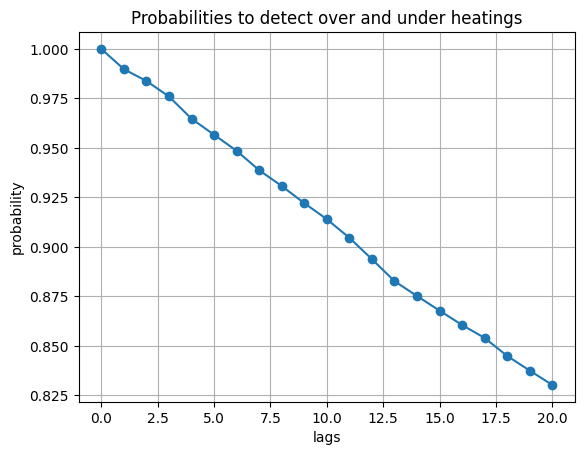

In [ ]:
data = pd.read_csv("Boiler/data_boiler.csv")

def create_dataset(lag):
    """
    create a lagged dataframe such that the explanatory variables are shifted by 'lag' relative to the target variable TE_8332A.AV_0

    @param lag : number of steps to shift the explanatory variables

    @return : the lagged dataframe such that : 
        - TE_8332A.AV_0#_t is at time t
        - all the explanatory variable are at time t-5*lag 

    """

    index = np.arange(lag)

    A = data[['date','TE_8332A.AV_0#']].drop(index).copy().reset_index(drop=True)
    A.columns = ['date','temperature']
    B = data.drop('date',axis=1).shift(lag).drop(index).copy().reset_index(drop=True)

    return pd.concat([A,B], axis=1)


def linear_reg(dataset, alpha=0.05):
    """
    Fit an Ordinary Least Squares (OLS) linear regression model and
    remove one by one all the  non significant variables based on their p-values (pvalue<0.05).

    @param dataset :  the dataFrame containing the target variable and the explanatory variables shifted by 'lag'

    @param alpha : the minimum p-value to remove an explanatory variable
     
    @return :  
        - the OLS model object that contains all the parameters of the regression
        - a list containing the removed variable
    """
    
    X = sm.add_constant(dataset.drop(['date','temperature'], axis=1))
    Y = dataset['temperature']

    removed_var = []
    
    while True:
        results = sm.OLS(Y, X).fit()
        pvalues = results.pvalues.drop('const')

        max_pval = pvalues.max()
        if max_pval > alpha:
            var_to_remove = pvalues.idxmax()
            X = X.drop([var_to_remove],axis=1)
            removed_var.append(var_to_remove)
        else:
            break
    
    return results, removed_var


lags = np.arange(21)
rapports = []
rapports_low = []
rapports_high = []

for lag in lags:
    dataset = create_dataset(lag)
    results, removed_var = linear_reg(dataset)
    removed_var.append('temperature')
    removed_var.append('date')
    y_predict = results.predict(sm.add_constant(dataset.drop(removed_var,axis=1)))

    N_low = 0
    n_low = 0
    N_high = 0
    n_high = 0

    for i in range(len(y_predict)):
        if dataset['temperature'].iloc[i] < 530 :
            N_low += 1
            if y_predict.iloc[i] < 530 :
                n_low += 1
        
        elif dataset['temperature'].iloc[i] > 545 :
            N_high += 1
            if y_predict.iloc[i] > 545 :
                n_high += 1
    
    N = N_low + N_high
    n = n_low + n_high

    rapport = n/N if N > 0 else np.nan
    rapports.append(rapport)

    rapport_low = n_low/N_low if N_low > 0 else np.nan
    rapports_low.append(rapport_low)

    rapport_high = n_high/N_high if N_high > 0 else np.nan
    rapports_high.append(rapport_high)


plt.plot(lags,rapports,marker='o')
plt.title("Probabilities to detect over and under heatings")
plt.xlabel('lags')
plt.ylabel('probability')
plt.grid(True)
plt.show()



Comment here: When testing different lag values, we observe that the model becomes less accurate as the lag increases. In particular, when the lag is higher than 11, the probability of correctly detecting overheating drops below 90%. This means that most of the useful information to predict overheating is found within the last 55 seconds (11 × 5 s) before the event.

c)  Compare the probabilities that your model detects over- and under-heatings. (**1 pt**)

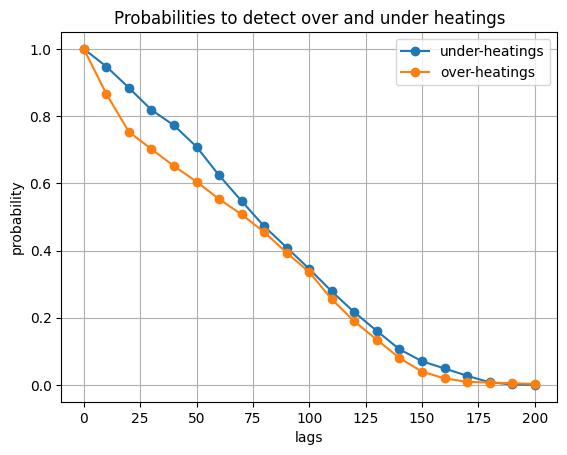

In [20]:
lags = np.arange(0,201,10)
rapports = []
rapports_low = []
rapports_high = []

for lag in lags:
    dataset = create_dataset(lag)
    results, removed_var = linear_reg(dataset)
    removed_var.append('temperature')
    removed_var.append('date')
    y_predict = results.predict(sm.add_constant(dataset.drop(removed_var,axis=1)))

    N_low = 0
    n_low = 0
    N_high = 0
    n_high = 0

    for i in range(len(y_predict)):
        if dataset['temperature'].iloc[i] < 530 :
            N_low += 1
            if y_predict.iloc[i] < 530 :
                n_low += 1
        
        elif dataset['temperature'].iloc[i] > 545 :
            N_high += 1
            if y_predict.iloc[i] > 545 :
                n_high += 1
    
    N = N_low + N_high
    n = n_low + n_high

    rapport = n/N if N > 0 else np.nan
    rapports.append(rapport)

    rapport_low = n_low/N_low if N_low > 0 else np.nan
    rapports_low.append(rapport_low)

    rapport_high = n_high/N_high if N_high > 0 else np.nan
    rapports_high.append(rapport_high)

plt.plot(lags,rapports_low, label='under-heatings',marker ='o')
plt.plot(lags,rapports_high,label='over-heatings',marker='o')
plt.title("Probabilities to detect over and under heatings")
plt.xlabel('lags')
plt.ylabel('probability')
plt.legend()
plt.grid(True)
plt.show()

Comment here: Overall, the probability of detecting underheating is higher than the probability of detecting overheating. Both probabilities decrease as the lag increases. After a lag of about 180 (900 seconds), the probabilities become almost zero, meaning the model can no longer detect over/underheating.